# Petrol Hourly Price Prediction

This is the starter code for the Petrol Hourly Prediction Dataset. It contains the following sections:

- Overview of the Dataset
- Exploratory Data Analysis
- Feature Engineering
- Model Selection
- Generate the Prediction File

## About the Petrol Hourly Price Dataset

### Overview

Petrol prices move up and down following certain patterns. Estimation of petrol prices can guide buying decisions for families and companies in order to reduce their regular expenses. The Petrol Hourly Price dataset is designed to offer insights into hourly fluctuations in petrol prices throughout the year 2022, specifically in Italy.your goal is to build regression models on historical records to forecast future petrol prices.

###  Input Variables

- id: the ID of the records.
- self_service: A binary flag indicating whether the data pertains to self-service fuel stations (1) or not (0).
- date: The timestamp representing the date and time of each recorded gasoline price.
- manager: The identity of the manager responsible for the fuel station.
- company: The name of the petrol company associated with the fuel station.
- station_category: The type or category of the fuel station, either "on urban street" or "on highway".
- station_name: The name of the fuel station.
- latitude: The latitude coordinate of the fuel station's location.
- longitude: The longitude coordinate of the fuel station's location.
- price: The recorded price of gasoline in euros (€) at the specified date and time.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math


from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
import xgboost as xgb
import lightgbm as lgb


## Load Data

In [2]:
# Load the labeled training data from a CSV file into a DataFrame
X_train = pd.read_csv('A1_petrol_price_labeled.csv')

# Load the kaggle test data from a CSV file into a DataFrame
X_kaggle = pd.read_csv('A1_petrol_price_kaggle.csv')

# Load the submission test data from a CSV file into a DataFrame
X_test = pd.read_csv('A1_petrol_price_submission.csv')


In [3]:
# Saving the 'id' columns into variables
train_ids = X_train['id']
test_ids = X_test['id']
kaggle_ids = X_kaggle['id']

# Dropping the 'id' columns from the data sets
X_train = X_train.drop('id', axis=1)
X_test = X_test.drop('id', axis=1)
X_kaggle = X_kaggle.drop('id', axis=1)


## Exploratory Data Analysis

## Check for missing values

In [4]:
# Calculate the number of missing values for each column in the training data
missing_values_train = X_train.isnull().sum()

# Calculate the number of missing values for each column in the test data
missing_values_test = X_test.isnull().sum()

# Calculate the number of missing values for each column in the kaggle data
missing_values_kaggle = X_kaggle.isnull().sum()

# Display the missing values for both training and test data
missing_values_train, missing_values_test,missing_values_kaggle

(self_service        0
 date_time           0
 manager             0
 company             0
 station_category    0
 station_name        0
 latitude            0
 longitude           0
 price               0
 dtype: int64,
 self_service        0
 date_time           0
 manager             0
 company             0
 station_category    0
 station_name        0
 latitude            0
 longitude           0
 price               0
 dtype: int64,
 self_service        0
 date_time           0
 manager             0
 company             0
 station_category    0
 station_name        0
 latitude            0
 longitude           0
 price               0
 dtype: int64)

## Feature Distribution

### Categorical Columns

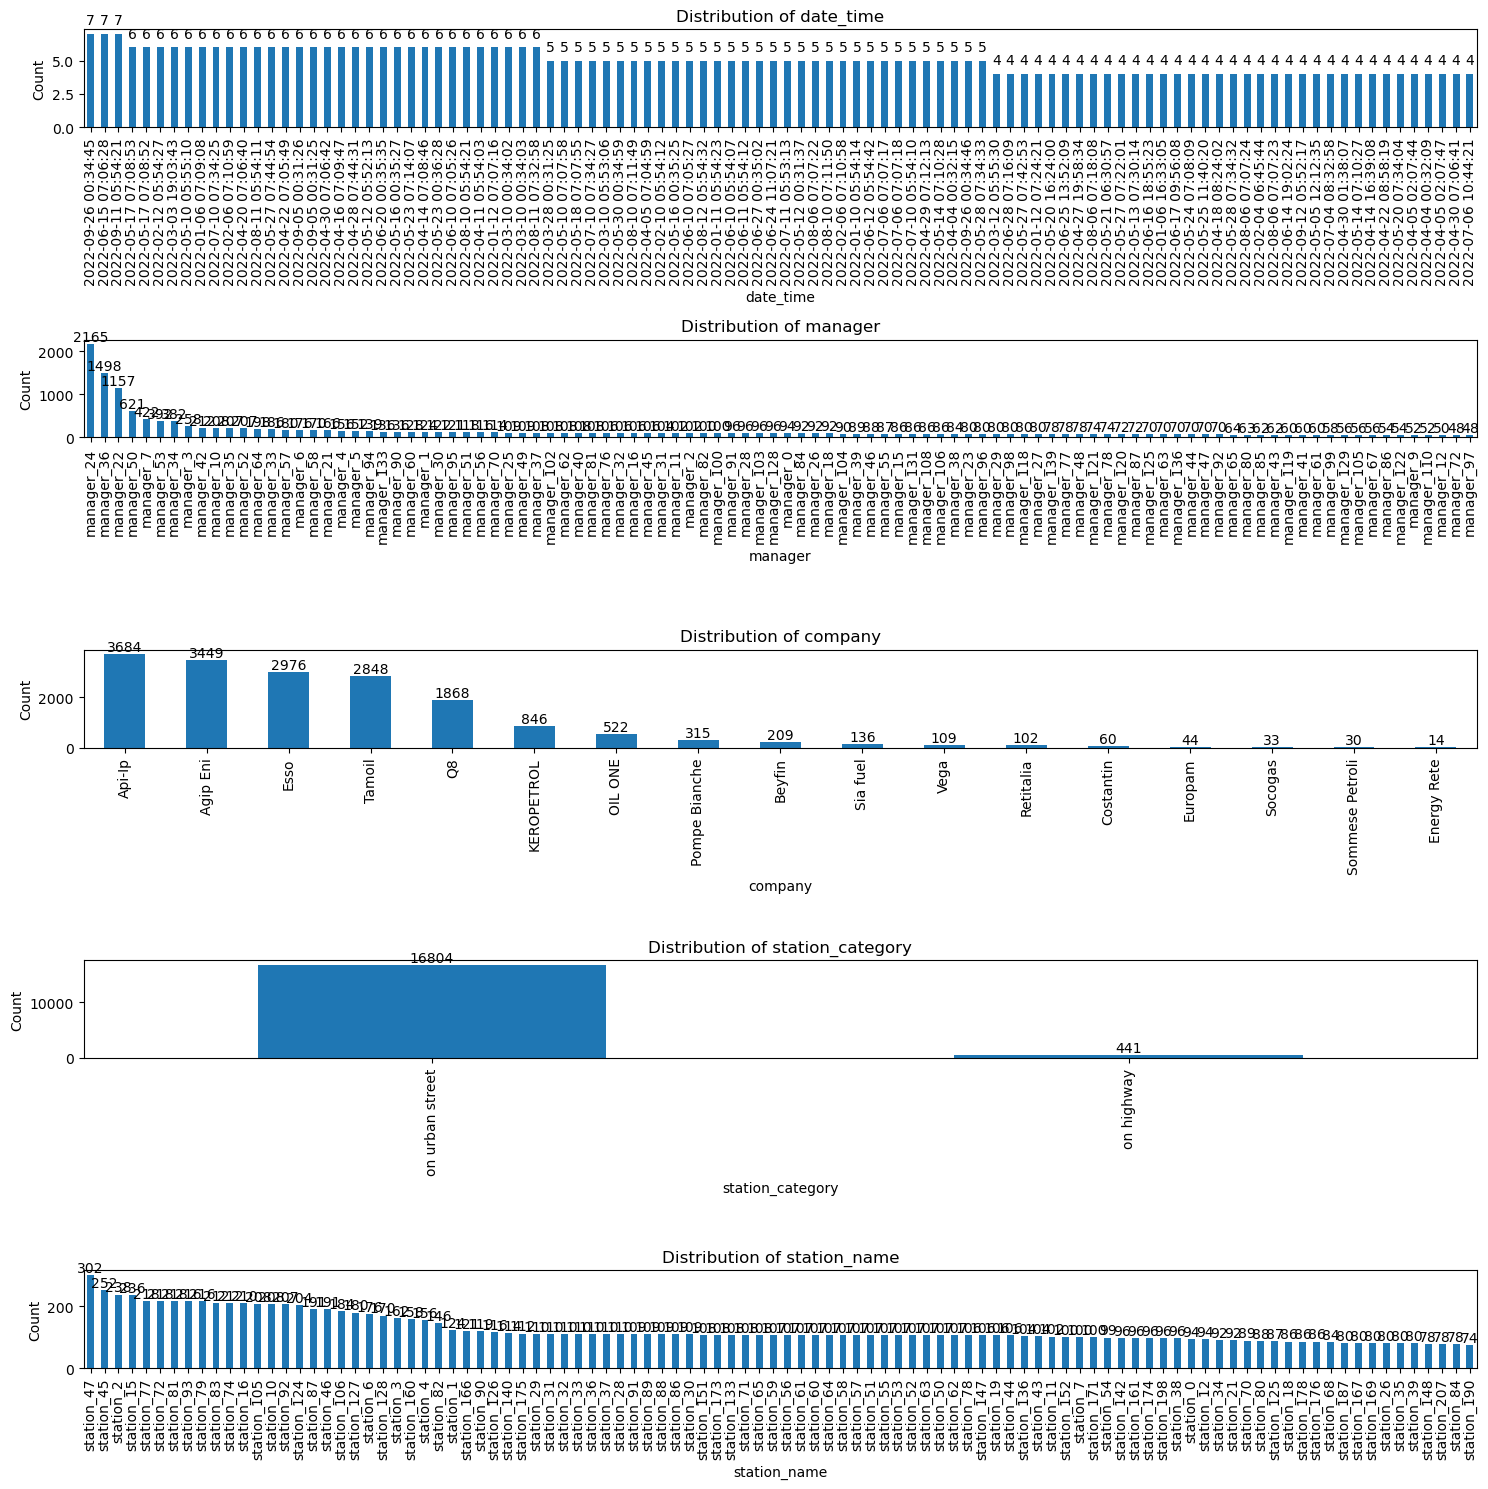

In [5]:
# Separate out the categorical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Plotting
fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(15, 15))

for i, col in enumerate(categorical_cols):
    counts = X_train[col].value_counts().head(100)  # Get top 20 categories
    counts.plot(kind='bar', ax=axes[i])  
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_ylabel('Count')

    # Add label on top of each bar
    for j, v in enumerate(counts):
        axes[i].text(j, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


### Numerical Columns

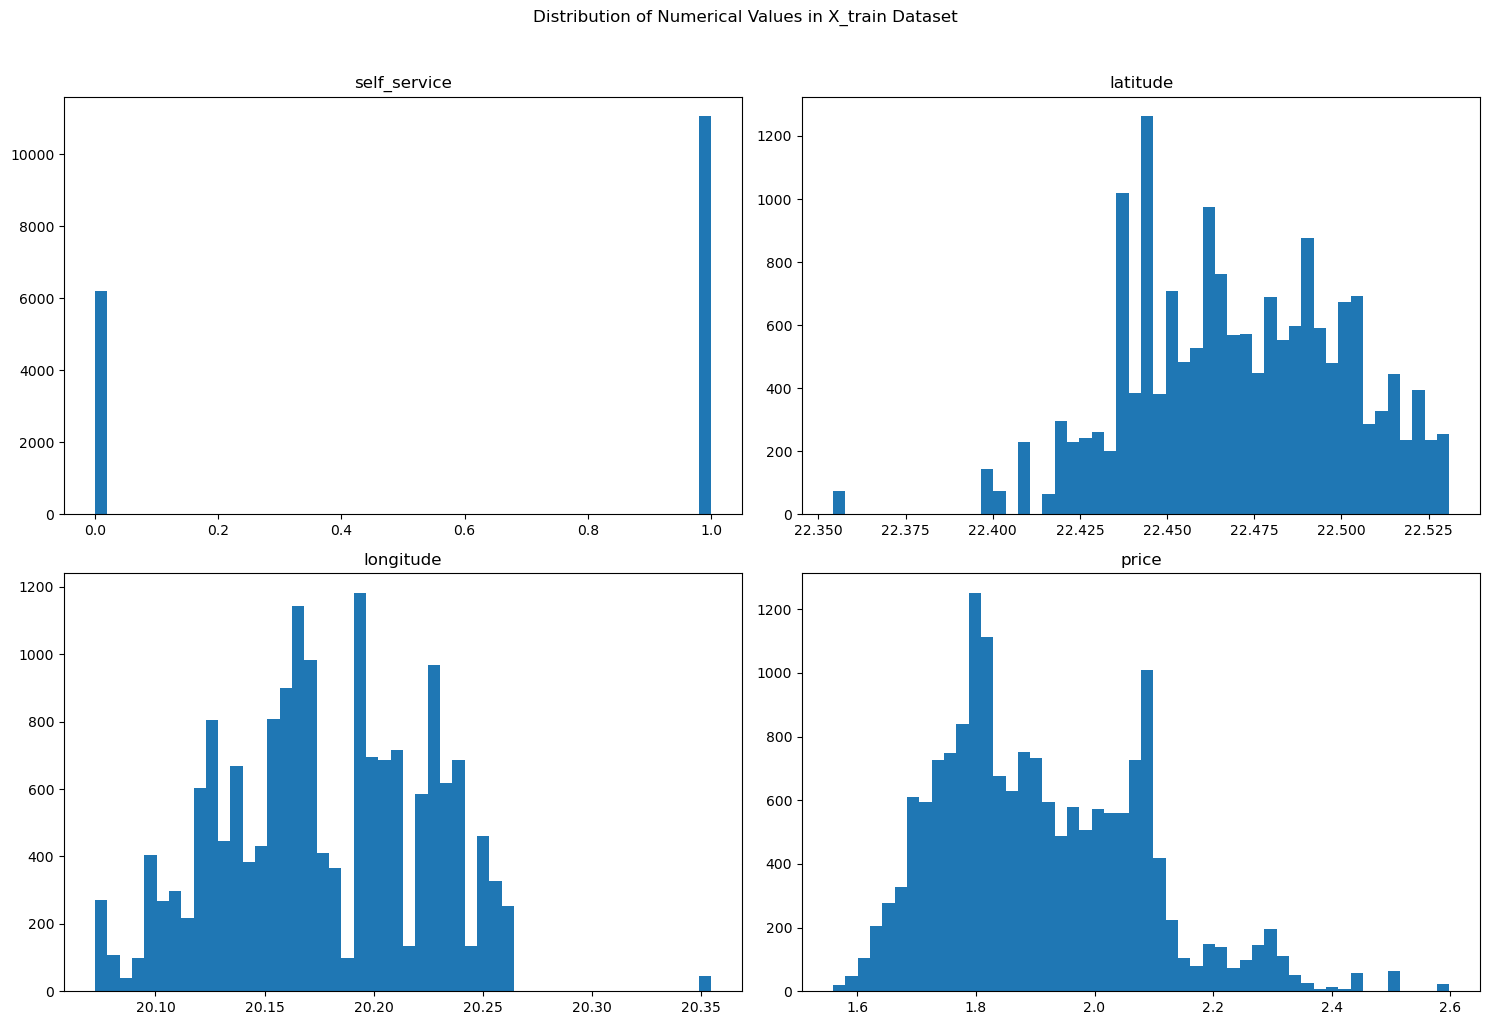

In [6]:
# Plot histograms for numerical columns
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
# Exclude 'id' and 'self_service' from the numerical columns list
X_train[numerical_cols].hist(figsize=(15, 10), bins=50, grid=False)
plt.suptitle('Distribution of Numerical Values in X_train Dataset', y=1.02)
plt.tight_layout()
plt.show()

### Checking for Outliers

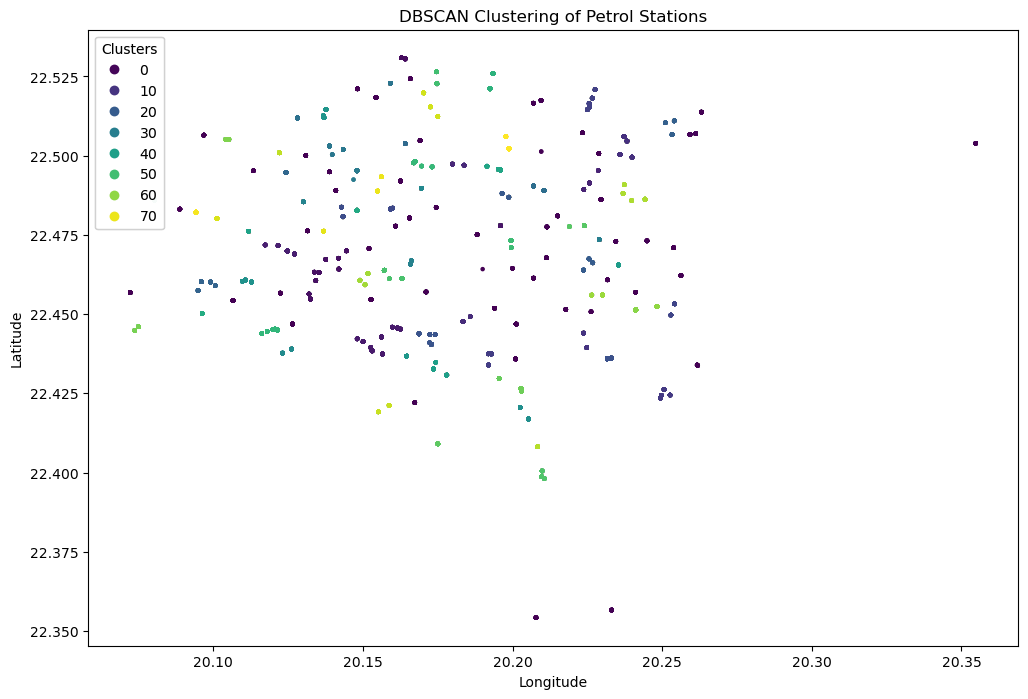

2574

In [7]:
from sklearn.cluster import DBSCAN
import numpy as np

# Extracting the latitude and longitude columns
coords = X_train[['latitude', 'longitude']].values

# Using DBSCAN to identify clusters and outliers
dbscan = DBSCAN(eps=0.005, min_samples=100)  # these parameters may need tuning based on domain knowledge
clusters = dbscan.fit_predict(coords)

# Plotting the results
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(X_train['longitude'], X_train['latitude'], c=clusters, cmap='viridis', s=5)
legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Clusters")
ax.add_artist(legend1)
ax.set_title('DBSCAN Clustering of Petrol Stations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Count of outliers (labelled as -1 by DBSCAN)
outliers_count = np.sum(clusters == -1)
outliers_count

In [8]:
# Calculate Q1, Q2 and IQR
Q1 = X_train['price'].quantile(0.25)
Q3 = X_train['price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = X_train[(X_train['price'] < lower_bound) | (X_train['price'] > upper_bound)]

X_train = X_train[(X_train['price'] >= lower_bound) & (X_train['price'] <= upper_bound)]


### Date time column data type

In [9]:
X_train['date_time'] = pd.to_datetime(X_train['date_time'], format='%Y-%m-%d %H:%M:%S')
X_test['date_time'] = pd.to_datetime(X_test['date_time'], format='%Y-%m-%d %H:%M:%S')
X_kaggle['date_time'] = pd.to_datetime(X_kaggle['date_time'], format='%Y-%m-%d %H:%M:%S')

### Date_time Feature Engineering

In [10]:
# Convert the 'date_time' column to datetime type and extract the year
X_train['year'] = pd.to_datetime(X_train['date_time']).dt.year
X_test['year'] = pd.to_datetime(X_test['date_time']).dt.year
X_kaggle['year'] = pd.to_datetime(X_kaggle['date_time']).dt.year

# Convert the 'date_time' column to datetime type and extract the month
X_train['month'] = pd.to_datetime(X_train['date_time']).dt.month
X_test['month'] = pd.to_datetime(X_test['date_time']).dt.month
X_kaggle['month'] = pd.to_datetime(X_kaggle['date_time']).dt.month

# Extract day from the 'date_time' column
X_train['day'] = X_train['date_time'].dt.day
X_test['day'] = X_test['date_time'].dt.day
X_kaggle['day'] = X_kaggle['date_time'].dt.day

# Define a function to categorize months into respective seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

# Apply the 'get_season' function to the 'month' column to get the season
X_train['season'] = X_train['month'].apply(get_season)
X_test['season'] = X_test['month'].apply(get_season)
X_kaggle['season'] = X_kaggle['month'].apply(get_season)

# Extract the day of the week from the 'date_time' column (0 = Monday, 6 = Sunday)
X_train['weekday'] = X_train['date_time'].dt.weekday
X_test['weekday'] = X_test['date_time'].dt.weekday
X_kaggle['weekday'] = X_kaggle['date_time'].dt.weekday

# Define a weekend based on the 'weekday' column (1 for Saturday and Sunday, otherwise 0)
X_train['weekend'] = X_train['weekday'].apply(lambda x: 1 if x >= 5 else 0)
X_test['weekend'] = X_test['weekday'].apply(lambda x: 1 if x >= 5 else 0)
X_kaggle['weekend'] = X_kaggle['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Extract hour from the 'date_time' column
X_train['hour'] = X_train['date_time'].dt.hour
X_test['hour'] = X_test['date_time'].dt.hour
X_kaggle['hour'] = X_kaggle['date_time'].dt.hour

# Define whether it's AM or PM based on the extracted 'hour'
X_train['am_pm'] = X_train['hour'].apply(lambda x: 'AM' if x < 12 else 'PM')
X_test['am_pm'] = X_test['hour'].apply(lambda x: 'AM' if x < 12 else 'PM')
X_kaggle['am_pm'] = X_kaggle['hour'].apply(lambda x: 'AM' if x < 12 else 'PM')


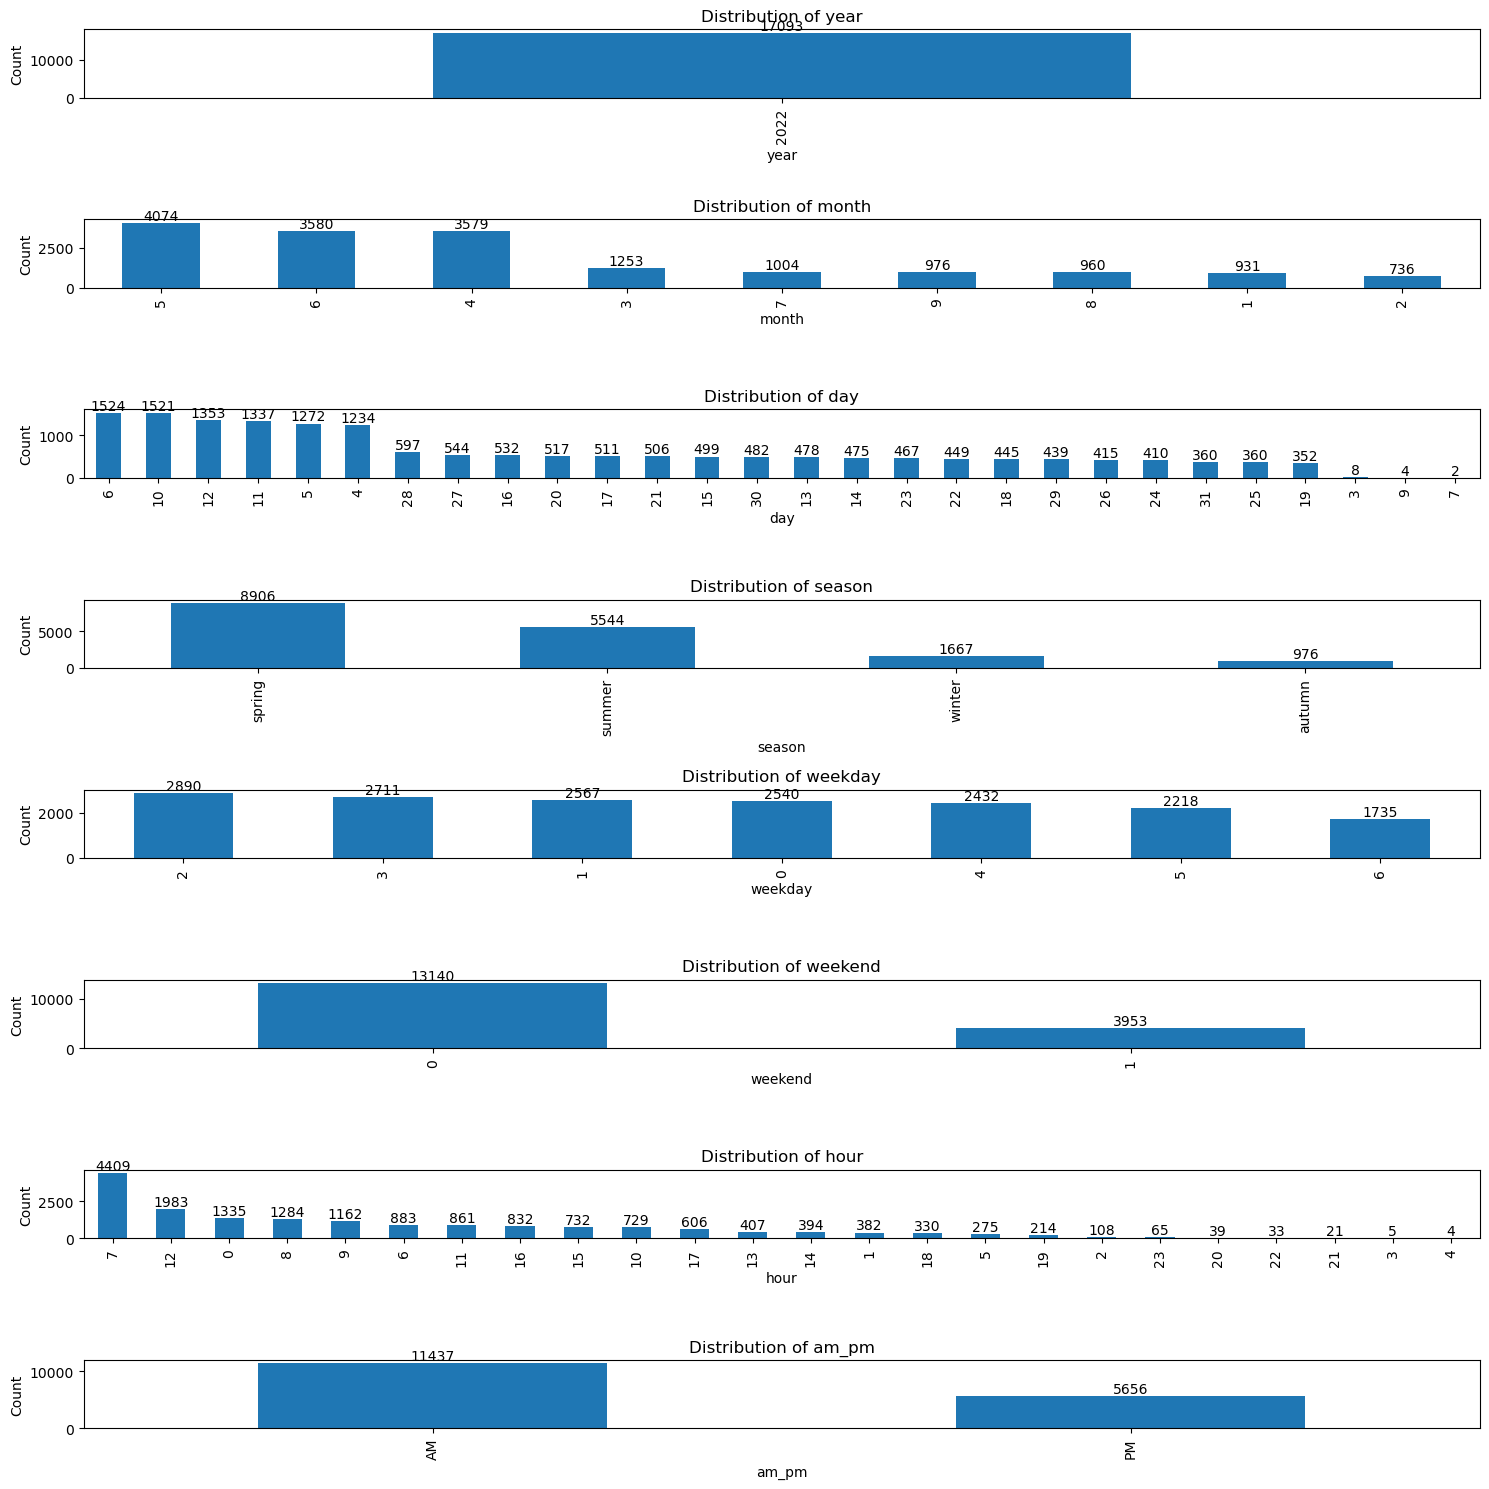

In [11]:
# List of new columns added to the training data
new_columns = ['year', 'month', 'day', 'season', 'weekday', 'weekend', 'hour', 'am_pm']

# Plotting
fig, axes = plt.subplots(len(new_columns), 1, figsize=(15, 15))

for i, col in enumerate(new_columns):
    counts = X_train[col].value_counts().head(50)  # Get top 50 categories (just in case)
    counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_ylabel('Count')

    # Add label on top of each bar
    for j, v in enumerate(counts):
        axes[i].text(j, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()



In [12]:
# Drop date_time and year from the data sets
X_train = X_train.drop(columns=['date_time','year'])
X_test = X_test.drop(columns=['date_time','year'])
X_kaggle = X_kaggle.drop(columns=['date_time','year'])

In [13]:
# Calculate the centroid
centroid = (X_train['latitude'].mean(), X_train['longitude'].mean())

def haversine(lat1, lon1, lat2, lon2):
    """Calculate the great-circle distance between two points on the Earth's surface."""
    R = 6371.0  # Radius of the Earth in km
    d_lat = math.radians(lat2 - lat1)
    d_lon = math.radians(lon2 - lon1)
    a = (math.sin(d_lat / 2) * math.sin(d_lat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(d_lon / 2) * math.sin(d_lon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

# Calculate the distance from each point to the centroid
X_train['distance_to_centroid'] = X_train.apply(
    lambda row: haversine(centroid[0], centroid[1], row['latitude'], row['longitude']),
    axis=1
)

X_test['distance_to_centroid'] = X_test.apply(
    lambda row: haversine(centroid[0], centroid[1], row['latitude'], row['longitude']),
    axis=1
)

X_kaggle['distance_to_centroid'] = X_kaggle.apply(
    lambda row: haversine(centroid[0], centroid[1], row['latitude'], row['longitude']),
    axis=1
)

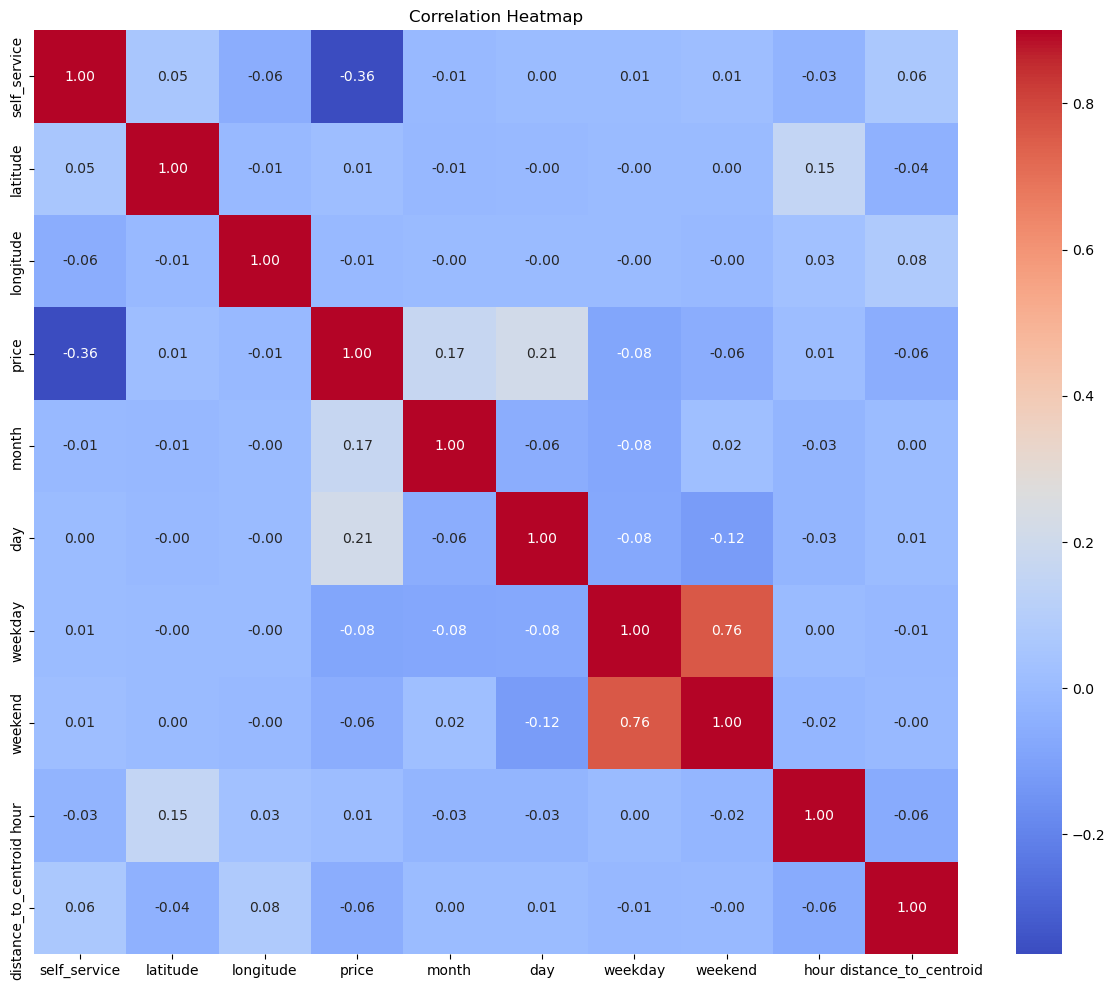

In [14]:
#Correlation matrix for our dataset 
numeric_cols = X_train.select_dtypes(include=[np.number])

corrmat = numeric_cols.corr() 
# Heatmap of the correlation matrix 
plt.figure(figsize=(15, 12)) 
sns.heatmap(corrmat, vmax=0.9, square=True, cmap="coolwarm", annot=True, fmt=".2f") 
plt.title("Correlation Heatmap") 
plt.show()

## Model Development and Selection

In [15]:
# Splitting the target variable from the features
y = X_train['price']
X = X_train.drop('price', axis=1)

# Split the dataset into training, testing, and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  # 80% train, 20% test


## Preprocessing Pipeline

In [16]:
# Define the features for preprocessing
categorical_features = [ 'manager','company', 'station_category', 'station_name','month', 'day',
       'season', 'weekend','weekday', 'hour', 'am_pm']
numerical_features = ['latitude','longitude','self_service','distance_to_centroid']

In [17]:
# Define Preprocessing pipeline with StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first',handle_unknown='infrequent_if_exist',min_frequency=70), categorical_features)
    ])

# Define Preprocessing pipeline with RobustScaler
robust_preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first',handle_unknown='infrequent_if_exist', min_frequency=70), categorical_features)
    ])

# Model SetUp

## Kernel Ridge Regression :

In [18]:
# Define hyperparameter search space for the Kernel Ridge regression model
krr_param_grid = [{
    'regressor__alpha': [0.6],
    'regressor__kernel': ['polynomial'],
    'regressor__degree': [2],
    'regressor__coef0': [2.5]
}]

# Construct a pipeline with preprocessing using 'preprocessor' followed by a Kernel Ridge regression model
krr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KernelRidge())
])


## XGBoost :

XGBoost, standing for eXtreme Gradient Boosting, is an optimized machine learning library that employs gradient boosted decision trees, a technique where new trees fix errors of their predecessors. Specifically in regression tasks, XGBoost predicts continuous, numeric outcomes by iteratively refining its model based on the residuals (differences between predicted and actual values). Advantages include its ability to handle missing data, regularization to prevent overfitting, and scalability. However, it may overfit if not carefully tuned and can struggle with primarily linear relationships.

In [19]:
# Define hyperparameter search space for the XGBoost regression model
xgb_param_grid = [{
    'regressor__learning_rate': [0.1],  # Step size shrinkage to prevent overfitting
    'regressor__max_depth': [ 6],  # Maximum depth of the individual trees
    'regressor__n_estimators': [2000],  # Number of boosting rounds
    'regressor__nthread': [-1]  # Number of parallel threads used to run XGBoost (-1 means using all threads)
}]

# Construct a pipeline with preprocessing using 'preprocessor' followed by an XGBoost regression model
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Initial preprocessing of data
    ('regressor', xgb.XGBRegressor())  # Regression model to fit the preprocessed data
])


### Evaluation Metric

The evaluation metric chosen for the model was the RMSE

Root Mean Squared Error (MSE) = $\sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - y_i)^2}$

## Experiment Tracking

In order to keep track of the different combinations of preprocessing techniques, model selection, and hyperparameter tunning, we decided to store each iteration as a distinct experiment. For each test we store the following data:
        
        "Experiment ID"
        "Date and Time
        "Comments"
        "Model or Pipeline
        "Model Name"
        "Hyperparameters"
        "Train RMSE"
        "Validation RMSE

Function to create id and timestamp for each experiment

In [20]:
from datetime import datetime  
import hashlib  

# Define a function to generate a current timestamp and its MD5 hash
def generate_timestamp_and_hash():
    # Get the current date and time in the specified format
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    # Compute the MD5 hash of the timestamp
    hash_id = hashlib.md5(timestamp.encode()).hexdigest()
    
    # Return the timestamp and its corresponding hash
    return timestamp, hash_id


Function to log each experiment

In [21]:
import json

def log_experiment(filename, grid_search_model, model_name, hyperparameters, train_rmse, val_rmse, comment):
    timestamp, hash_id = generate_timestamp_and_hash()

    # Create a dictionary to hold experiment details
    experiment_data = {
        "Experiment ID": hash_id,
        "Date and Time": timestamp,
        "Comments": comment,
        "Model (from GridSearchCV)": str(grid_search_model.best_estimator_),
        "Model Name": model_name,
        "Hyperparameters": hyperparameters,
        "Train RMSE": train_rmse,
        "Validation RMSE": val_rmse
    }

    with open(filename, 'a') as f:
        # Write the dictionary as a JSON object with proper formatting and indentation
        json.dump(experiment_data, f, ensure_ascii=False, indent=4)
        f.write("\n\n")  # Add extra new lines for readability



## Kernel Ridge Model

In [22]:
# Initialize GridSearchCV with the Regressor pipeline and its hyperparameters
model_kernel = GridSearchCV(
    krr_pipeline,                # Regressor
    param_grid=krr_param_grid,   # Hyperparameters 
    cv=5,                        # 5-fold cross validation
    scoring='neg_mean_squared_error', # Negative Mean Squared Error as the scoring metric
    refit='neg_mean_squared_error'    # Refit the best model using the entire dataset based on NMSE
)

# Fit the GridSearchCV model to the training data
model_kernel.fit(X_train, y_train)

# Display the GridSearchCV object
model_kernel

c:\Users\santiago.contreras\Anaconda3\envs\Ticket_Classification\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\santiago.contreras\Anaconda3\envs\Ticket_Classification\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['latitude',
                                                                          'longitude',
                                                                          'self_service',
                                                                          'distance_to_centroid']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='infrequent_if_exist',
                                                                                       min_frequency=70),
                                                                         ['manager',
                                                                          'company',
                                                                          'station_category',
                                                                          'station_name',
                                                                          'month',
                                                                          'day',
                                                                          'season',
                                                                          'weekend',
                                                                          'weekday',
                                                                          'hour',
                                                                          'am_pm'])])),
                                       ('regressor', KernelRidge())]),
             param_grid=[{'regressor__alpha': [0.6], 'regressor__coef0': [2.5],
                          'regressor__degree': [2],
                          'regressor__kernel': ['polynomial']}],
             refit='neg_mean_squared_error', scoring='neg_mean_squared_error')

## XGBoost Model

In [23]:
# Initialize GridSearchCV with the Regressor pipeline and its hyperparameters
model = GridSearchCV(
    xgb_pipeline,                # Regressor
    param_grid=xgb_param_grid,   # Hyperparameters 
    cv=5,                        # 5-fold cross validation
    scoring='neg_mean_squared_error', # Negative Mean Squared Error as the scoring metric
    refit='neg_mean_squared_error'    # Refit the best model using the entire dataset based on NMSE
)

# Fit the GridSearchCV model to the training data
model.fit(X_train, y_train)

# Display the GridSearchCV object
model


c:\Users\santiago.contreras\Anaconda3\envs\Ticket_Classification\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\santiago.contreras\Anaconda3\envs\Ticket_Classification\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['latitude',
                                                                          'longitude',
                                                                          'self_service',
                                                                          'distance_to_centroid']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='infrequent_if_exist',
                                                                                       min_frequency=70),
                                                                         ['manager',
                                                                          'company',
                                                                          'station_category',
                                                                          'station_name',
                                                                          'month',
                                                                          'day',
                                                                          'season',
                                                                          'we...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             param_grid=[{'regressor__learning_rate': [0.1],
                          'regressor__max_depth': [6],
                          'regressor__n_estimators': [2000],
                          'regressor__nthread': [-1]}],
             refit='neg_mean_squared_error', scoring='neg_mean_squared_error')

### Experiment variables

In [24]:
# Obtain the best pipeline from the trained model
best_pipeline = model_kernel.best_estimator_

# Predict on training and validation sets
train_predictions = best_pipeline.predict(X_train)
val_predictions = best_pipeline.predict(X_val)

# Calculate the RMSE for training and validation sets
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))

# Access the 'regressor' component of the pipeline
inner_model = best_pipeline.named_steps['regressor']

# Get the name of the model
model_name = type(inner_model).__name__

# Extract hyperparameters of the model
hyperparameters = inner_model.get_params()

# Comment for the experiment
comment = "Kernel Ridge Model"

# Log the experiment details
log_experiment("experiments.json", model, model_name, hyperparameters, train_rmse, val_rmse,comment)

# Return the name of the model and the RMSE values
model_name,train_rmse,val_rmse

('KernelRidge', 0.0752630768611301, 0.07441234412824163)

In [25]:
# Obtain the best pipeline from the trained model
best_pipeline = model.best_estimator_

# Predict on training and validation sets
train_predictions = best_pipeline.predict(X_train)
val_predictions = best_pipeline.predict(X_val)

# Calculate the RMSE for training and validation sets
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))

# Access the 'regressor' component of the pipeline
inner_model = best_pipeline.named_steps['regressor']

# Get the name of the model
model_name = type(inner_model).__name__

# Extract hyperparameters of the model
hyperparameters = inner_model.get_params()

# Comment for the experiment
comment = "random forest test"

# Log the experiment details
log_experiment("experiments.json", model, model_name, hyperparameters, train_rmse, val_rmse,comment)

# Return the name of the model and the RMSE values
model_name,train_rmse,val_rmse


('XGBRegressor', 0.015003836886612167, 0.03973501800150991)

## Experiment Results

The experiment file can be read back into a df for further analysis

In [26]:
def parse_json_to_df(filename):
    # List to hold all experiment data
    experiments = []
    
    # Open the file for reading
    with open(filename, 'r') as f:
        # Read the entire content of the file and strip any leading/trailing whitespace
        content = f.read().strip()
        
        # Split the content by two newline characters, assuming each JSON object is separated by two newlines
        experiments_data = content.split("\n\n")
        
        # Iterate over each piece of data (which should be a JSON string)
        for data in experiments_data:
            # Convert the JSON string to a Python dictionary
            experiment = json.loads(data)
            
            # Add the dictionary to the experiments list
            experiments.append(experiment)

    # Convert the list of dictionaries to a DataFrame and return
    return pd.DataFrame(experiments)




In [27]:
# Call the function
experiment_df = parse_json_to_df("experiments.json")
experiment_df.head()

,Experiment ID,Date and Time,Comments,Model (from GridSearchCV),Model Name,Hyperparameters,Train RMSE,Validation RMSE
0,8057c6721d81018e75e1c73752359782,2023-09-12 09:38:05,base run for every model,"Pipeline(steps=[('preprocessor',\n ...",Lasso,"{'alpha': 0.0005, 'copy_X': True, 'fit_interce...",0.149106,0.147945
1,b993d115e882a84f949064cd6bd7839c,2023-09-12 09:38:06,base run for every model,"Pipeline(steps=[('preprocessor',\n ...",LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.141244,0.141543
2,22c173ebe1780d1e52f9c83f30ec8cbb,2023-09-12 09:38:16,base run for every model,"Pipeline(steps=[('preprocessor',\n ...",ElasticNet,"{'alpha': 0.0005, 'copy_X': True, 'fit_interce...",0.148568,0.147480
3,d5c0999166616f81a34781d64346b341,2023-09-12 09:39:17,base run for every model,"Pipeline(steps=[('preprocessor',\n ...",KernelRidge,"{'alpha': 0.6, 'coef0': 2.5, 'degree': 2, 'gam...",0.142194,0.141816
4,02ea6561675dd06ef642e49d91382ee9,2023-09-12 09:41:21,base run for every model,"Pipeline(steps=[('preprocessor',\n ...",GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",0.135921,0.137474


In [28]:
min_row = experiment_df.loc[experiment_df['Validation RMSE'].idxmin()]
min_row


Experiment ID                                 f2f81f54e9f24f07c2be1b895ae2973b
Date and Time                                              2023-09-18 21:23:54
Comments                                                    random forest test
Model (from GridSearchCV)    Pipeline(steps=[('preprocessor',\n            ...
Model Name                                                        XGBRegressor
Hyperparameters              {'objective': 'reg:squarederror', 'base_score'...
Train RMSE                                                            0.015004
Validation RMSE                                                       0.039735
Name: 99, dtype: object

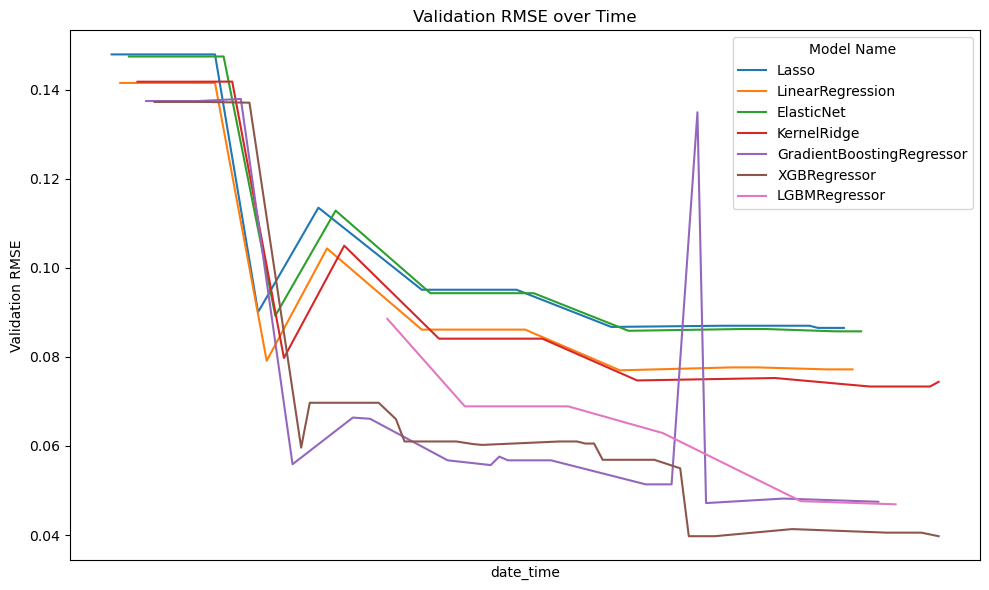

In [29]:
# Convert the 'date_time' column to datetime format and then to string
experiment_df['date_time'] = pd.to_datetime(experiment_df['Date and Time']).astype(str)

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=experiment_df, x='date_time', y='Validation RMSE', hue='Model Name')
plt.title('Validation RMSE over Time')
plt.xticks([], [])  # This will hide the x-axis labels
plt.tight_layout()
plt.show()

## Generating the Prediction File

In [30]:
y_pred_test = best_pipeline.predict(X_test)

y_pred_kaggle = best_pipeline.predict(X_kaggle)


c:\Users\santiago.contreras\Anaconda3\envs\Ticket_Classification\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\santiago.contreras\Anaconda3\envs\Ticket_Classification\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [31]:
df_pred = pd.concat([kaggle_ids, pd.DataFrame(y_pred_kaggle, columns=['price'])], axis = 1)
df_pred.to_csv('pred_values_kaggle.csv',index=False)

In [32]:
df_pred = pd.concat([test_ids, pd.DataFrame(y_pred_test,columns=['pred'])], axis = 1)
df_pred.to_csv('pred_values.csv',index=False)